# Personalized Medicine Recommending System

## Author = Subash Palvel

# Importing Necessary Python Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Words to Vectors Library
from sklearn.feature_extraction.text import CountVectorizer

# Similarity and Distance Metrics Library
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.stats import pearsonr
from scipy.spatial import distance
from Levenshtein import distance as levenshtein_distance

In [4]:
import wordnet

# Data Extraction and Exploratory Analysis

In [5]:
test = pd.read_csv('drugsComTest_raw.csv', na_values=['(NA)']).fillna(0)
train = pd.read_csv('drugsComTrain_raw.csv', na_values=['(NA)']).fillna(0)

In [6]:
df = pd.concat([test, train], ignore_index=True, sort=False)
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [7]:
# Converting 'Rating' and 'UsefulCount' into float type for generating new column of 'most_reviewed' drugs
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['usefulCount'] = pd.to_numeric(df['usefulCount'], errors='coerce')
df['most_reviewed'] = df['rating'] * df['usefulCount']

In [8]:
df = df[['uniqueID','drugName','condition','review','most_reviewed']]
df.head()

,uniqueID,drugName,condition,review,most_reviewed
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",220
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",136
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",27
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",315
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",36


# Plotting the graph for Top 10 Most Reviewed Drugs

In [9]:
#Sorting Top 10 Drugs in Dataset
df = df.sort_values(by='most_reviewed', ascending=False, ignore_index=True)
df = df.drop_duplicates(subset = ['condition'], ignore_index=True)
df = df.drop_duplicates(subset = ['drugName'], ignore_index=True)
df_graph = df[['drugName','most_reviewed']]
df_graph = df_graph.head(10)
df_graph

,drugName,most_reviewed
0,Zoloft,12910
1,Mirena,12470
2,Phentermine,7960
3,OxyContin,6255
4,Citalopram,5544
5,BuSpar,5265
6,Clomiphene,4860
7,Topiramate,4670
8,Denosumab,4480
9,Amoxicillin,4080


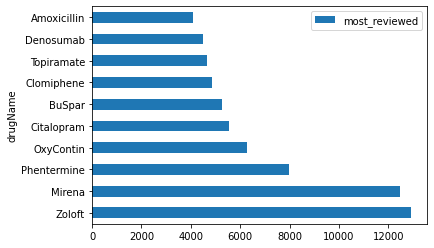

In [10]:
df_graph.plot(kind='barh', x='drugName', y='most_reviewed')
plt.show()

In [11]:
#Removing unwanted characters and splitting in words the string value of 'Review' column
df['review'] = df['review'].map(lambda x: re.sub(r'["&#039;"]','', x))
df['review'] = df['review'].apply(lambda x: x.split())
df['review'].values

array([list(['I', 'remember', 'reading', 'peoples', 'opinions,', 'online,', 'of', 'the', 'drug', 'before', 'I', 'took', 'it', 'and', 'it', 'scared', 'me', 'away', 'from', 'it.', 'Then', 'I', 'finally', 'decided', 'to', 'give', 'it', 'a', 'try', 'and', 'it', 'has', 'been', 'the', 'best', 'choice', 'I', 'have', 'made.', 'I', 'have', 'been', 'on', 'it', 'for', 'over', '4', 'months', 'and', 'I', 'feel', 'great.', 'Im', 'on', '1mg', 'and', 'I', 'dont', 'have', 'any', 'side', 'effects.', 'When', 'I', 'first', 'started', 'I', 'did', 'notice', 'that', 'my', 'hands', 'would', 'tremble', 'but', 'then', 'it', 'subsided.', 'So', 'honestly,', 'dont', 'listen', 'to', 'all', 'the', 'negativity', 'because', 'what', 'doesnt', 'work', 'for', 'some', 'works', 'amazing', 'for', 'others.', 'So', 'go', 'based', 'on', 'youself', 'and', 'not', 'everyone', 'else.', 'It', 'may', 'be', 'a', 'blessing', 'in', 'diguise.', 'The', 'pill', 'is', 'not', 'meant', 'to', 'make', 'you', 'be', 'all', 'happy', 'go', 'lucky'

In [12]:
# Now Concatnating Drugs and Condition values with Reviews to build metadata of drugs
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['condition_list'] = df['condition'].apply(lambda x: "".join(x))
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: "".join(x))

In [13]:
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())

In [14]:
df['tags'] = df['drugName_list'] + df['condition_list'] + df['review']

In [15]:
df.head()

,uniqueID,drugName,condition,review,most_reviewed,condition_list,drugName_list,tags
0,119152,Zoloft,Depression,"[I, remember, reading, peoples, opinions,, onl...",12910,[Depression],[Zoloft],"[Zoloft, Depression, I, remember, reading, peo..."
1,182560,Mirena,Birth Control,"[I, have, had, my, IUD, for, over, a, year, no...",12470,"[Birth, Control]",[Mirena],"[Mirena, Birth, Control, I, have, had, my, IUD..."
2,139141,Phentermine,Weight Loss,"[I, have, used, this, pill, off, and, on, for,...",7960,"[Weight, Loss]",[Phentermine],"[Phentermine, Weight, Loss, I, have, used, thi..."
3,151366,OxyContin,Pain,"[Ahhhh,, the, dreaded, drug...no, matter, what...",6255,[Pain],[OxyContin],"[OxyContin, Pain, Ahhhh,, the, dreaded, drug....."
4,62688,Citalopram,Anxiety and Stress,"[I, work, for, a, large, Fire, Department., I,...",5544,"[Anxiety, and, Stress]",[Citalopram],"[Citalopram, Anxiety, and, Stress, I, work, fo..."


In [16]:
#Creating New Dataframe with relevant columns for further analysis
new_df = df[['uniqueID','drugName','condition','tags']]
new_df

,uniqueID,drugName,condition,tags
0,119152,Zoloft,Depression,"[Zoloft, Depression, I, remember, reading, peo..."
1,182560,Mirena,Birth Control,"[Mirena, Birth, Control, I, have, had, my, IUD..."
2,139141,Phentermine,Weight Loss,"[Phentermine, Weight, Loss, I, have, used, thi..."
3,151366,OxyContin,Pain,"[OxyContin, Pain, Ahhhh,, the, dreaded, drug....."
4,62688,Citalopram,Anxiety and Stress,"[Citalopram, Anxiety, and, Stress, I, work, fo..."
...,...,...,...,...
605,67246,Omeprazole,Multiple Endocrine Adenomas,"[Omeprazole, Multiple, Endocrine, Adenomas, ex..."
606,131191,Hepatitis b adult vaccine,Hepatitis B Prevention,"[Hepatitis, b, adult, vaccine, Hepatitis, B, P..."
607,88838,Mumps virus vaccine,Mumps Prophylaxis,"[Mumps, virus, vaccine, Mumps, Prophylaxis, Lo..."
608,41891,"Rabies vaccine, human diploid cell",Rabies Prophylaxis,"[Rabies, vaccine,, human, diploid, cell, Rabie..."


In [17]:
new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())

C:\Users\Subash Palvel\AppData\Local\Temp\ipykernel_5672\711323875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))
C:\Users\Subash Palvel\AppData\Local\Temp\ipykernel_5672\711323875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


In [18]:
new_df['tags'][0]

'zoloft depression i remember reading peoples opinions, online, of the drug before i took it and it scared me away from it. then i finally decided to give it a try and it has been the best choice i have made. i have been on it for over 4 months and i feel great. im on 1mg and i dont have any side effects. when i first started i did notice that my hands would tremble but then it subsided. so honestly, dont listen to all the negativity because what doesnt work for some works amazing for others. so go based on youself and not everyone else. it may be a blessing in diguise. the pill is not meant to make you be all happy go lucky and see quotbutterflies and rosesquot, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. i still get sad some times, but that is normal, that is life, and its up to people to take control to make a change. i did so by getting on this pill.'

# Stemming using NLTK Library and comparing results 

In [19]:
# PorterStemmer is applied to check root words
ps = PorterStemmer()
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [20]:
new_df_ps = new_df[['uniqueID','drugName','condition','tags']]
new_df_ps['tags'] = new_df_ps['tags'].apply(stem)
new_df_ps['tags'][0]

'zoloft depress i rememb read peopl opinions, online, of the drug befor i took it and it scare me away from it. then i final decid to give it a tri and it ha been the best choic i have made. i have been on it for over 4 month and i feel great. im on 1mg and i dont have ani side effects. when i first start i did notic that my hand would trembl but then it subsided. so honestly, dont listen to all the neg becaus what doesnt work for some work amaz for others. so go base on youself and not everyon else. it may be a bless in diguise. the pill is not meant to make you be all happi go lucki and see quotbutterfli and rosesquot, it meant to help put the chemic in your mind in balanc so you can just be who you are and not overli depressed. i still get sad some times, but that is normal, that is life, and it up to peopl to take control to make a change. i did so by get on thi pill.'

In [21]:
# WordNetLemmatizer is also deployed to check root words and meaning consistency
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemma(text):
    y = []
    for i in text.split():
        y.append(wordnet_lemmatizer.lemmatize(i, pos="v"))
        
    return " ".join(y)

#  Implementing Count Vectorizer to make words in vector form

In [27]:
# Max Features is set to 500 a d stop words are removed from string
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text
cv = CountVectorizer(max_features=500, stop_words='english', analyzer='word', preprocessor=preprocess_text)

In [28]:
# Applying Fit Transform to Lemma processed vector as it give more relevant meaning
vectors = cv.fit_transform(new_df_lemma['tags']).toarray()
vectors[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,

In [29]:
# Getting Top 500 most used words from bag of words of 'Tags' column values
cv.get_feature_names_out()

array(['able', 'absolutely', 'aches', 'acid', 'acne', 'active',
       'actually', 'acute', 'affect', 'afternoon', 'age', 'ago', 'alive',
       'allergic', 'allergies', 'amazing', 'amp', 'anti', 'antibiotic',
       'anxiety', 'anymore', 'appetite', 'area', 'arthritis',
       'associated', 'attack', 'attacks', 'away', 'awesome', 'baby',
       'bacterial', 'bad', 'barely', 'bathroom', 'bed', 'began',
       'believe', 'best', 'better', 'big', 'birth', 'bit', 'bladder',
       'bleeding', 'blood', 'body', 'bone', 'bowel', 'brain', 'breast',
       'breath', 'breathing', 'burning', 'came', 'cance', 'cancer',
       'care', 'case', 'cause', 'caused', 'causes', 'cell', 'change',
       'changed', 'chest', 'chronic', 'clear', 'cleared', 'close', 'cold',
       'combination', 'come', 'comment', 'completely', 'condition',
       'conditions', 'congestion', 'constant', 'constantly',
       'constipation', 'continue', 'continued', 'control', 'cost',
       'cough', 'count', 'couple', 'course'

# Evaluating Model with Various Similarity and Distances Metrices

In [30]:
# Pearson Correlation with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    corr, _ = pearsonr(vectors[0],vectors[i])
    l.append(corr)
    print('Pearsons correlation: %.3f' % corr)
avg=np.mean(l)
print('Pearsons correlation average: %.3f' % avg)

Pearsons correlation: 0.021
Pearsons correlation: 0.044
Pearsons correlation: 0.065
Pearsons correlation: 0.093
Pearsons correlation: 0.165
Pearsons correlation: 0.117
Pearsons correlation: 0.060
Pearsons correlation: 0.118
Pearsons correlation: 0.017
Pearsons correlation: 0.041
Pearsons correlation average: 0.074


In [31]:
# Cosine Similarity with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    cos_sim = cosine_similarity(vectors[0].reshape(1,-1),vectors[i].reshape(1,-1))
    l.append(cos_sim)
    print('Cosine similarity: %.3f' % cos_sim)
avg=np.mean(l)
print('Cosine similarity average: %.3f' % avg)

Cosine similarity: 0.163
Cosine similarity: 0.140
Cosine similarity: 0.171
Cosine similarity: 0.043
Cosine similarity: 0.000
Cosine similarity: 0.065
Cosine similarity: 0.154
Cosine similarity: 0.000
Cosine similarity: 0.106
Cosine similarity: 0.071
Cosine similarity average: 0.091


In [32]:
# Jaccard's similarity among two first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    jacc = jaccard_score(vectors[0],vectors[i], average='macro')
    l.append(jacc)
    print('Jaccard similarity: %.3f' % jacc)
avg=np.mean(l)
print('Jaccard similarity average: %.3f' % avg)

Jaccard similarity: 0.314
Jaccard similarity: 0.244
Jaccard similarity: 0.302
Jaccard similarity: 0.228
Jaccard similarity: 0.326
Jaccard similarity: 0.311
Jaccard similarity: 0.246
Jaccard similarity: 0.196
Jaccard similarity: 0.310
Jaccard similarity: 0.311
Jaccard similarity average: 0.279


In [33]:
#Euclidean Distance between two first drug and random drugs
for i in random.sample(range(1, 600), 10):
    dst = distance.euclidean(vectors[0],vectors[i])
    print('Euclidean distance: %.3f' % dst)

Euclidean distance: 8.944
Euclidean distance: 8.124
Euclidean distance: 6.928
Euclidean distance: 8.775
Euclidean distance: 8.367
Euclidean distance: 7.937
Euclidean distance: 7.483
Euclidean distance: 8.775
Euclidean distance: 7.280
Euclidean distance: 8.367


In [34]:
#Manhattan Distance between two first drug and random drugs
for i in random.sample(range(1, 600), 10):
    dst = distance.cityblock(vectors[0],vectors[i])
    print('Manhattan distance: %.3f' % dst)

Manhattan distance: 62.000
Manhattan distance: 54.000
Manhattan distance: 75.000
Manhattan distance: 48.000
Manhattan distance: 47.000
Manhattan distance: 57.000
Manhattan distance: 51.000
Manhattan distance: 48.000
Manhattan distance: 70.000
Manhattan distance: 55.000


# Building Recommender system

In [35]:
# Choosing Cosine Similarity for recommender system building
similarity = cosine_similarity(vectors)
similarity[0]

array([1.        , 0.13949717, 0.18731716, 0.17149859, 0.18116433,
       0.12126781, 0.21009029, 0.07559289, 0.19051587, 0.12060454,
       0.15960478, 0.09701425, 0.16858545, 0.31703757, 0.05547002,
       0.06488857, 0.1069045 , 0.16865481, 0.09486833, 0.13333333,
       0.10101525, 0.31622777, 0.21213203, 0.10606602, 0.0792118 ,
       0.        , 0.08944272, 0.02324953, 0.12      , 0.08488747,
       0.13471506, 0.        , 0.        , 0.        , 0.24748737,
       0.10886621, 0.2       , 0.06324555, 0.        , 0.06666667,
       0.20655911, 0.05080005, 0.02886751, 0.13598002, 0.07878386,
       0.13764944, 0.11795356, 0.10886621, 0.12792043, 0.0942809 ,
       0.10606602, 0.26222491, 0.05773503, 0.13363062, 0.04685213,
       0.09258201, 0.30508511, 0.1       , 0.06469966, 0.15396007,
       0.11094004, 0.12060454, 0.15491933, 0.125     , 0.07302967,
       0.14729194, 0.16329932, 0.03922323, 0.05345225, 0.20252642,
       0.12792043, 0.10327956, 0.0792118 , 0.1767767 , 0.17056

In [36]:
# Sorting similarity in descending orders to make more similar drugs on top.
sorted((list(enumerate(similarity[2]))), reverse=True, key=lambda x:x[1])[0:11]

[(2, 1.0),
 (543, 0.3456831719160075),
 (380, 0.32780503405359285),
 (555, 0.3228000831375015),
 (521, 0.32124628310161774),
 (12, 0.2982456140350877),
 (135, 0.29740593873973137),
 (247, 0.29388734334825806),
 (563, 0.28097574347450816),
 (347, 0.2665569949915916),
 (375, 0.2660079583736709)]

In [37]:
#Defing a function to recommend drug based on condition selected
def recommend(condition):
    drug_index = new_df_lemma[new_df_lemma['condition'] == condition].index[0]
    distances = similarity[drug_index]
    drug_list = sorted((list(enumerate(distances))), reverse=True, key=lambda x:x[1])[0:5]
    for i in drug_list:
        print(new_df_lemma.iloc[i[0]].drugName)

In [38]:
# Testing the Recommender system
recommend('Varicose Veins')

Horse chestnut
Multivitamin
Turmeric
Mobic
Lactulose
